### Comparison between PEC and Coherence

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from brainconn.centrality import participation_coef
from brainconn.modularity import modularity_louvain_dir, modularity_louvain_und
from frites.conn.conn_tf import _create_kernel, _smooth_spectra
from frites.stats import confidence_interval
from frites.utils import parallel_func
from scipy.stats import ks_2samp, mannwhitneyu, ttest_1samp
from statannot import add_stat_annotation
from tqdm import tqdm
from utils import *

from config import get_dates, return_evt_dt
from GDa.graphics import plot
from GDa.loader import loader
from GDa.stats.bursting import find_activation_sequences, find_start_end
from GDa.temporal_network import temporal_network
from GDa.util import _extract_roi
from GDa.temporal_network import temporal_network

#### Auxiliar functions

In [3]:
def plot_adj_modular(
    A, ci, offset=0.5, vmin=0, vmax=0.05, cmap="turbo", lw=5, color="k"
):
    """
    Plot a modular adjacency matrix with community boundaries.

    This function takes a adjacency matrix (A), a vector of community indices (ci), and optional arguments for
    plotting the matrix (offset, vmin, vmax, cmap, lw, color) and plots the adjacency matrix with lines denoting
    the boundaries between communities.

    Parameters:
    A (ndarray or xr.DataArray): adjacency matrix
    ci (ndarray): vector of community indices for each node in the adjacency matrix
    offset (float): offset for the community boundaries. Default is 0.5
    vmin (float): minimum value for color map. Default is 0
    vmax (float): maximum value for color map. Default is 0.05
    cmap (str): name of colormap to use. Default is 'turbo'
    lw (float): width of the lines used to draw the community boundaries. Default is 5
    color (str): color of the lines used to draw the community boundaries. Default is 'k'
    """
    _, c = np.unique(ci, return_counts=True)

    N = len(A)

    c = np.cumsum(c)
    c = np.hstack(([0], c))

    idx = np.argsort(ci)
    rois = A.sources.data[idx]

    if isinstance(A, xr.DataArray):
        plot_data = A.data[np.ix_(idx, idx)]
    else:
        plot_data = A[np.ix_(idx, idx)]
    plt.imshow(plot_data, vmin=vmin, vmax=vmax, cmap=cmap, origin="lower")
    plt.xticks(range(N), rois, rotation=90)
    plt.yticks(range(N), rois)

    for i in range(1, len(c)):
        plt.hlines(
            c[i - 1] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color
        )
        plt.vlines(
            c[i - 1] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color
        )
        plt.hlines(c[i] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color)
        plt.vlines(c[i] - offset, c[i] - offset, c[i - 1] - offset, lw=lw, color=color)

#### Setting configurations

In [4]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [5]:
metric = "coh"
monkey = "lucy"

In [6]:
sessions = get_dates(monkey)

In [7]:
stages = [[-0.4, 0], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

In [8]:
colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

In [9]:
data_loader = loader(_ROOT=_ROOT)

In [10]:
kw_loader = dict(
    session="141024", aligned_at="cue", channel_numbers=False, monkey=monkey
)

In [23]:
def return_power(trial_type=1, behavioral_response=1):
    power = []
    for session in tqdm(sessions):

        kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

        temp = data_loader.load_power(
            **kw_loader, trial_type=trial_type, behavioral_response=behavioral_response, session=session
        )
        
        #temp = (temp - temp.mean("times")) / temp.std("times")

        temp_2 = []
        for ti, tf in stages:
            temp_2 += [temp.sel(times=slice(ti, tf)).mean(("times", "trials"))]

        temp_2 = xr.concat(temp_2, "times")

        power += [temp_2]

    power = data_loader.apply_min_rois(power, 10).sel(roi=t_pow.roi)
    return power

In [24]:
power_task = return_power(1, 1)
power_fix = return_power(2, 0)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:05<00:00, 10.63it/s]


In [11]:
path = os.path.expanduser("~/funcog/gda/Results/lucy/mutual_information/power")

p_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path, "pval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_0.nc")
    )
)
t_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path, "tval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_0.nc")
    )
)

In [11]:
net = temporal_network(coh_file="pec_at_cue.nc", coh_sig_file=None,
                       date="141024", freqs_slice=[27],
                       trial_type=[1], behavioral_response=[1])

net.convert_to_adjacency()

A_pec = []
for ti, tf in stages:
    A_pec += [net.A.sel(freqs=27, times=slice(ti, tf)).mean(("times", "trials"))]
A_pec = xr.concat(A_pec, "times")

net = temporal_network(coh_file="coh_at_cue.nc", coh_sig_file="thr_coh_at_cue_surr.nc",
                       date="141024", freqs_slice=[27],
                trial_type=[1], behavioral_response=[1])

net.convert_to_adjacency()

A_coh = []
for ti, tf in stages:
    A_coh += [net.A.sel(freqs=27, times=slice(ti, tf)).mean(("times", "trials"))]
A_coh = xr.concat(A_coh, "times")
    
net = temporal_network(coh_file="plv_at_cue.nc", coh_sig_file="thr_plv_at_cue_surr.nc",
                       date="141024", freqs_slice=[27],
                trial_type=[1], behavioral_response=[1])

net.convert_to_adjacency()

A_plv = []
for ti, tf in stages:
    A_plv += [net.A.sel(freqs=27, times=slice(ti, tf)).mean(("times", "trials"))]
A_plv = xr.concat(A_plv, "times")

In [12]:
areas_dict = get_areas()

In [13]:
regions = np.asarray([areas_dict[roi.lower()] for roi in net.A.sources.data])

roi_s = net.A.sources.values

regions = [areas_dict[r.lower()] for r in roi_s]

from sklearn import preprocessing

pre = preprocessing.LabelEncoder()
pre.fit(regions)
ci_ = pre.transform(regions) + 1

In [14]:
def set_ticks_square(ticks="x", fontsize=5):
    if ticks == "x":
        f_ticks = plt.xticks
    else:
        f_ticks = plt.yticks
    tks = f_ticks(fontsize=fontsize)
    channels = [tks[1][i].get_text() for i in range(len(tks[1]))]
    f_ticks(range(len(tks[1])), ["■"] * len(tks[1]))
    tks_color = [colors[areas_dict[roi.lower()]] for roi in channels]
    [tks[1][i].set_color(tks_color[i]) for i in range(len(tks[1]))]

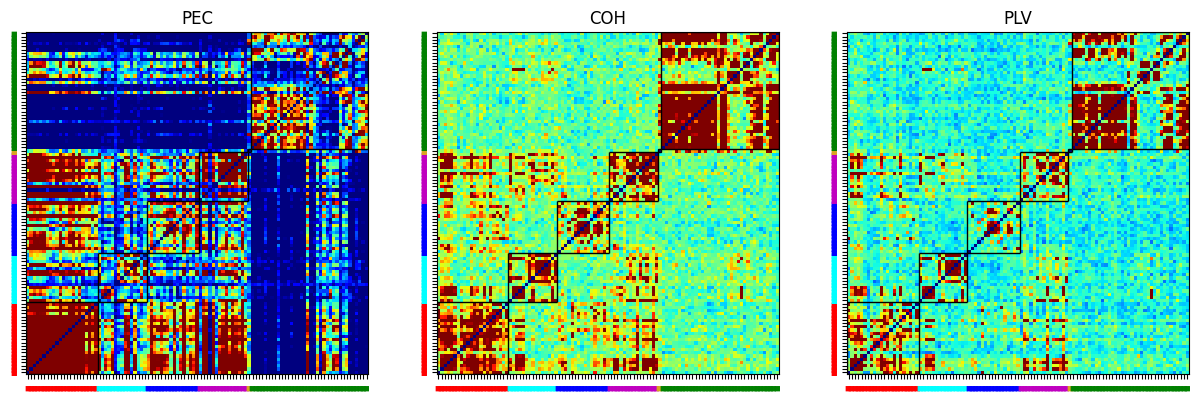

In [15]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plot_adj_modular(
    A_pec.isel(times=0),
    ci_,
    offset=0.5,
    vmin=0,
    vmax=0.3,
    cmap="jet",
    color="k",
    lw=1,
)
plt.title("PEC")
plt.xticks(fontsize=5);
set_ticks_square(ticks="x", fontsize=5)
set_ticks_square(ticks="y", fontsize=5)

plt.subplot(1, 3, 2)
plot_adj_modular(
    A_coh.isel(times=0),
    ci_,
    offset=0.5,
    vmin=0,
    vmax=0.01,
    cmap="jet",
    color="k",
    lw=1,
)
plt.title("COH")
plt.xticks(fontsize=5);
set_ticks_square(ticks="x", fontsize=5)
set_ticks_square(ticks="y", fontsize=5)

plt.subplot(1, 3, 3)
plot_adj_modular(
    A_plv.isel(times=0),
    ci_,
    offset=0.5,
    vmin=0,
    vmax=0.01,
    cmap="jet",
    color="k",
    lw=1,
)
plt.title("PLV")
plt.xticks(fontsize=5);
set_ticks_square(ticks="x", fontsize=5)
set_ticks_square(ticks="y", fontsize=5)

Text(0, 0.5, 'AVG. PLV D1 27 Hz')

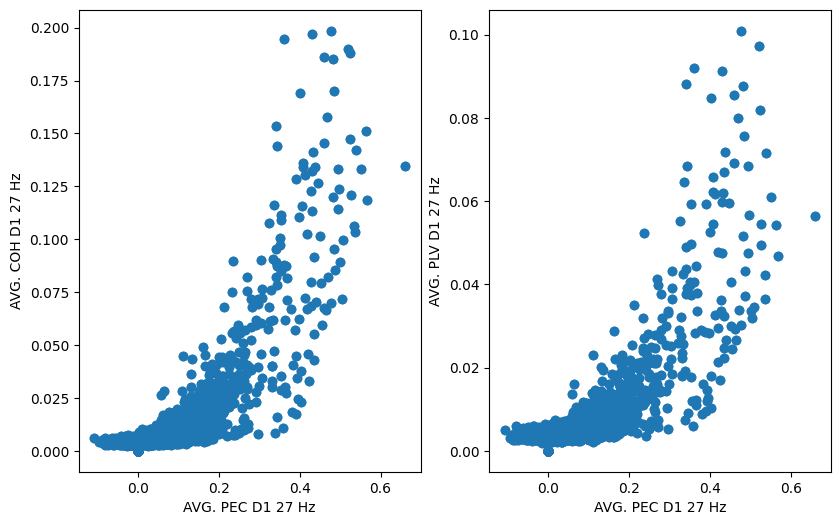

In [16]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.scatter(A_pec.isel(times=3).data.flatten(), A_coh.isel(times=3).data.flatten())
plt.xlabel("AVG. PEC D1 27 Hz")
plt.ylabel("AVG. COH D1 27 Hz")

plt.subplot(1, 3, 2)
plt.scatter(A_pec.isel(times=3).data.flatten(), A_plv.isel(times=3).data.flatten())
plt.xlabel("AVG. PEC D1 27 Hz")
plt.ylabel("AVG. PLV D1 27 Hz")

In [17]:
net_pec = temporal_network(coh_file="pec_at_cue.nc", coh_sig_file=None,
                       date="141024", freqs_slice=[27],
                       trial_type=[1], behavioral_response=[1])

net_coh = temporal_network(coh_file="coh_at_cue.nc", coh_sig_file="thr_coh_at_cue_surr.nc",
                       date="141024", freqs_slice=[27],
                       trial_type=[1], behavioral_response=[1])

100%|██████████████████████████████████████████████████████████████████████████████████████| 582/582 [00:02<00:00, 211.18it/s]


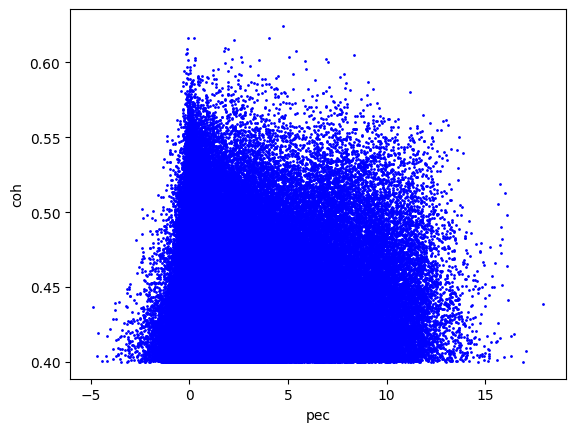

In [18]:
for i in tqdm(range(net_pec.super_tensor.sizes["trials"])):
    x = net_pec.super_tensor.isel(trials=i).squeeze()
    y = net_coh.super_tensor.isel(trials=i).squeeze()

    x = x.data.flatten()
    y = y.data.flatten()

    plt.scatter(x[y > .4],
                y[y > .4], c="b", s=1)

    plt.ylabel("coh")
    plt.xlabel('pec')

In [31]:
mu = np.zeros(10)
session = "141024"
net_pec = temporal_network(coh_file="pec_at_cue.nc", coh_sig_file=None,
                       date=session, freqs_slice=[27],
                       trial_type=[1], behavioral_response=[1])

net_coh = temporal_network(coh_file="coh_at_cue.nc", coh_sig_file="thr_coh_at_cue_surr.nc",
                       date=session, freqs_slice=[27],
                       trial_type=[1], behavioral_response=[1])

i0 = 3
i1 = 5


for i in tqdm(range(10)):
    out = np.logical_and(net_pec.super_tensor.squeeze() > i0 + i * 2, 
                   net_pec.super_tensor.squeeze() <= i1 + i * 2) * net_coh.super_tensor.squeeze()
    out = out.data.flatten()#[out.data.flatten() > 0]

    mu[i] = out.mean()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.15s/it]


Text(0.5, 0, 'Size of PEC event (STDs)')

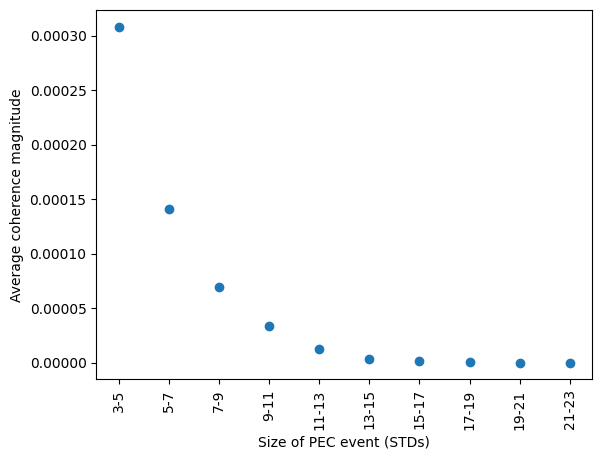

In [32]:
xlabels = [f"{i0 + i * 2}-{i1 + i * 2}" for i in range(10)]

plt.scatter(range(10), mu)
plt.xticks(range(10), xlabels, rotation=90);
plt.ylabel("Average coherence magnitude")
plt.xlabel("Size of PEC event (STDs)")

In [33]:
i0 = .01
i1 = .02
plt.figure(figsize=(15, 6))
mu = []
for i in tqdm(range(12)):
    #plt.subplot(2, 5, i + 1)
    out = np.logical_and(net_coh.super_tensor.squeeze() > i0 + i * .03, 
                   net_coh.super_tensor.squeeze() <= i1 + i * .03) * net_pec.super_tensor.squeeze()
    out = out.data.flatten()#[out.data.flatten() > 0]

    #plt.hist(out, np.linspace(0, .5, 10), density=True)
    
    mu += [out.mean()]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.20s/it]


<Figure size 1500x600 with 0 Axes>

Text(0.5, 0, 'Size of COH event (STDs)')

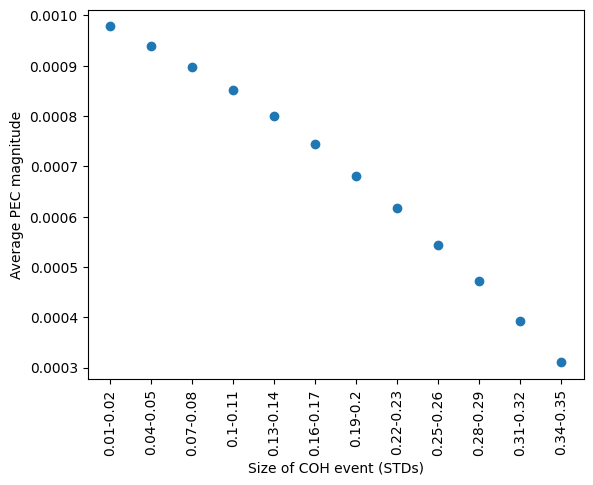

In [34]:
xlabels = [f"{np.round(i0 + i * .03, 3)}-{np.round(i1 + i * .03, 3)}" for i in range(12)]

plt.scatter(range(12), mu)
plt.xticks(range(12), xlabels, rotation=90);
plt.ylabel("Average PEC magnitude")
plt.xlabel("Size of COH event (STDs)")

### PID

In [35]:
import numpy as np
import xarray as xr
from frites.config import CONFIG
from frites.conn import conn_io
from frites.core import copnorm_nd, mi_model_nd_gd, mi_nd_gg
from frites.io import check_attrs, logger, set_log_level
from mne.utils import ProgressBar


def _mi_estimation(x, y, mi_type):
    """Compute the MI on each roi.
    x.shape = (n_times, {1, Nd}, n_trials)
    y.shape = ({1, Nd}, n_trials)
    """
    x = np.ascontiguousarray(x)
    cfg_mi = CONFIG["KW_GCMI"]
    if mi_type == "cc":
        y = np.atleast_2d(y)[np.newaxis, ...]
        # repeat y to match x shape
        y = np.tile(y, (x.shape[0], 1, 1))
        return mi_nd_gg(x, y, **cfg_mi)
    elif mi_type == "cd":
        return mi_model_nd_gd(x, y, **cfg_mi)


def conn_pid(
    data,
    y,
    roi=None,
    times=None,
    mi_type="cc",
    gcrn=True,
    dt=1,
    sfreq=None,
    verbose=None,
    **kw_links,
):
    """Compute the Partial Information Decomposition on connectivity pairs.
    This function can be used to untangle how the information about a stimulus
    is carried inside a brain network.
    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :
            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)
    y : array_like
        The feature of shape (n_trials,). This feature vector can either be
        categorical and in that case, the mutual information type has to 'cd'
        or y can also be a continuous regressor and in that case the mutual
        information type has to be 'cc'
    roi : array_like | None
        Array of region of interest name of shape (n_roi,)
    times : array_like | None
        Array of time points of shape (n_times,)
    mi_type : {'cc', 'cd'}
        Mutual information type. Switch between :
            * 'cc' : if the y input is a continuous regressor
            * 'cd' : if the y input is a discret vector with categorical
              integers inside
    gcrn : bool | True
        Specify if the Gaussian Copula Rank Normalization should be applied.
        Default is True.
    kw_links : dict | {}
        Additional arguments for selecting links to compute are passed to the
        function :func:`frites.conn.conn_links`
    Returns
    -------
    mi_node : array_like
        The array of mutual infromation estimated on each node of shape
        (n_roi, n_times)
    unique : array_like
        The unique contribution of each node of shape (n_roi, n_times)
    infotot : array_like
        The total information in the network of shape (n_pairs, n_times)
    redundancy : array_like
        The redundancy in the network of shape (n_pairs, n_times)
    synergy : array_like
        The synergy in the network of shape (n_pairs, n_times)
    See also
    --------
    conn_links
    """
    # _________________________________ INPUTS ________________________________
    # inputs conversion
    kw_links.update({"directed": False, "net": False})
    data, cfg = conn_io(
        data,
        y=y,
        times=times,
        roi=roi,
        agg_ch=False,
        win_sample=None,
        name="PID",
        sfreq=sfreq,
        verbose=verbose,
        kw_links=kw_links,
    )

    # extract variables
    x, attrs = data.data, cfg["attrs"]
    y, roi, times = data["y"].data, data["roi"].data, data["times"].data
    x_s, x_t = cfg["x_s"], cfg["x_t"]
    roi_p, n_pairs = cfg["roi_p"], len(x_s)

    assert dt >= 1
    # build the indices when using multi-variate mi
    idx = np.mgrid[0 : len(times) - dt + 1, 0:dt].sum(0)
    times = times[idx].mean(1)
    n_trials, n_roi, n_times = len(y), len(roi), len(times)

    logger.info(f"Compute PID on {n_pairs} connectivity pairs")
    # gcrn
    if gcrn:
        logger.info("    Apply the Gaussian Copula Rank Normalization")
        x = copnorm_nd(x, axis=0)
        if mi_type == "cc":
            y = copnorm_nd(y, axis=0)

    # get the mi function to use
    fcn = {"cc": mi_nd_gg, "cd": mi_model_nd_gd}[mi_type]

    # transpose the data to be (n_roi, n_times, 1, n_trials)
    x = np.transpose(x, (1, 2, 0))

    # __________________________________ PID __________________________________
    # compute mi on each node of the network
    logger.info("    Estimating PID in the network")
    pbar = ProgressBar(range(2 * n_roi + n_pairs), mesg="Estimating MI on each node")
    mi_node = np.zeros((n_roi, n_times), dtype=float)
    for n_r in range(n_roi):
        mi_node[n_r, :] = _mi_estimation(x[n_r, idx, :], y, mi_type)
        pbar.update_with_increment_value(1)

    pbar._tqdm.desc = "Estimating total information and redundancy"
    infotot = np.zeros((n_pairs, n_times))
    redundancy = np.zeros((n_pairs, n_times))
    for n_p, (s, t) in enumerate(zip(x_s, x_t)):
        _x_s, _x_t = x[s, ...], x[t, ...]

        # total information estimation
        x_st = np.concatenate((_x_s[idx, ...], _x_t[idx, ...]), axis=1)
        infotot[n_p, :] = _mi_estimation(x_st, y, mi_type)

        # redundancy estimation
        redundancy[n_p, :] = np.c_[mi_node[s, :], mi_node[t, :]].min(1)

        pbar.update_with_increment_value(1)

    # estimate the unique information
    pbar._tqdm.desc = "Estimating unique information and synergy"
    unique = np.zeros((n_roi, n_times))
    for n_r in range(n_roi):
        idx_red = np.logical_or(x_s == n_r, x_t == n_r)
        if not np.any(idx_red):  # some pairs might be absent
            continue
        red_all = redundancy[idx_red, :].min(0)
        unique[n_r, :] = mi_node[n_r, :] - red_all
        pbar.update_with_increment_value(1)

    # feature specific synergy
    synergy = infotot - mi_node[x_s, :] - mi_node[x_t, :] + redundancy

    # _______________________________ OUTPUTS _________________________________
    kw = dict(dims=("roi", "times"), coords=(roi, times), attrs=check_attrs(attrs))
    kw_pairs = dict(dims=("roi", "times"), coords=(roi_p, times))
    mi_node = xr.DataArray(mi_node, name="mi_node", **kw)
    unique = xr.DataArray(unique, name="Unique", **kw)
    infotot = xr.DataArray(infotot, name="Infotot", **kw_pairs)
    redundancy = xr.DataArray(redundancy, name="Redundancy", **kw_pairs)
    synergy = xr.DataArray(synergy, name="Synergy", **kw_pairs)

    return mi_node, unique, infotot, redundancy, synergy

In [36]:
net_pec = temporal_network(coh_file="pec_at_cue.nc", coh_sig_file=None,
                       date="141024", freqs_slice=[27],
                       trial_type=[1], behavioral_response=[1])

net_coh = temporal_network(coh_file="coh_at_cue.nc", coh_sig_file="thr_coh_at_cue_surr.nc",
                       date="141024", freqs_slice=[27],
                       trial_type=[1], behavioral_response=[1])

In [37]:
data = xr.concat((net_pec.super_tensor.squeeze(),
net_coh.super_tensor.squeeze()), "metric")

In [38]:
data = data.assign_coords({"metric": ["pec", "coh"]})

In [39]:
y = data.attrs["stim"]

In [40]:
data = data.transpose("roi", "trials", "metric", "times")

In [41]:
roi, times = data.metric.data, data.times.data

In [ ]:
I, U, S, R = [], [], [], []
for i in tqdm(range(data.sizes["roi"])):
    data_sel = data.isel(roi=i).transpose("trials", "metric", "times")
    mi_node, unique, infotot, redundancy, synergy = conn_pid(
        data_sel,
        y,
        roi="metric",
        times="times",
        mi_type="cd",
        gcrn=True,
        dt=10,
        sfreq=None,
        verbose=False)

    I += [infotot]
    U += [unique.rename({"roi": "metric"})]
    S += [synergy]
    R += [redundancy]

  1%|▋                                                                                      | 40/5460 [00:12<28:08,  3.21it/s]

In [111]:
infotot = xr.concat(I, "roi")
unique = xr.concat(U, "roi")
synergy = xr.concat(S, "roi")
redundancy = xr.concat(R, "roi")

In [112]:
roi_s, roi_t = _extract_roi(data.roi.data, "-")

In [113]:
reg_s = np.array([areas_dict[r.lower()] for r in roi_s])
reg_t = np.array([areas_dict[r.lower()] for r in roi_t])

In [114]:
regions = np.unique((reg_s, reg_t))

In [115]:
ii, jj = np.triu_indices(6, k=1)

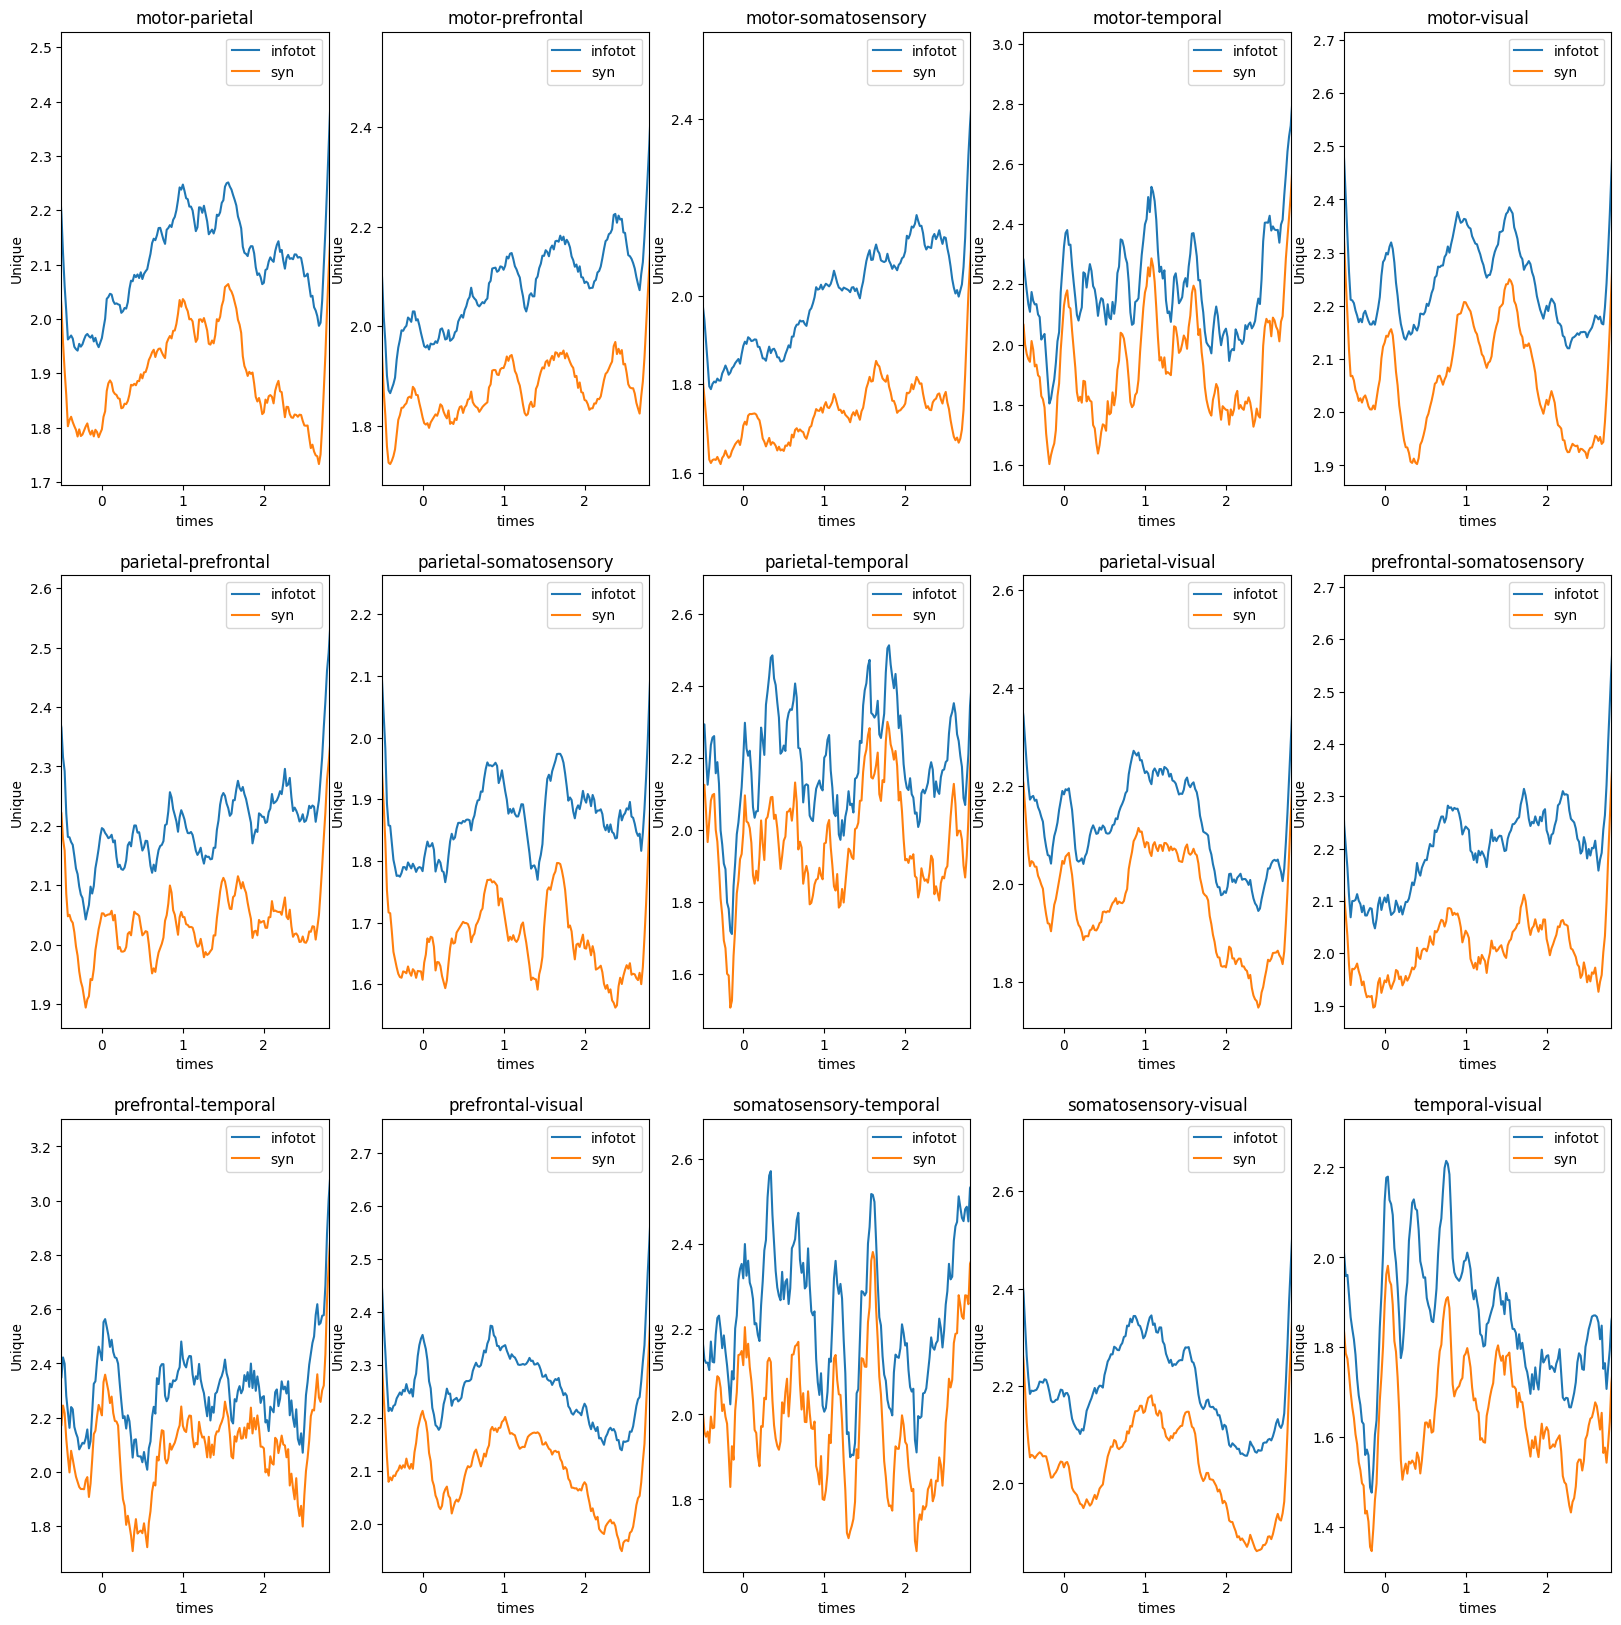

In [119]:
plt.figure(figsize=(20, 20))
pos = 1
for rs, rt in zip(regions[ii], regions[jj]):
    
    plt.subplot(3, 5, pos)
    
    idx = np.logical_or(
        np.logical_and(reg_s == rs, reg_t==rt),
        np.logical_and(reg_s == rt, reg_t==rs)
    )

    x = infotot.isel(roi=idx).mean("roi")
    y = synergy.isel(roi=idx).mean("roi")
    z = redundancy.isel(roi=idx).mean("roi")


    u1 = unique.isel(roi=idx).mean("roi").sel(metric="pec")
    u2 = unique.isel(roi=idx).mean("roi").sel(metric="coh")
    
    
    x.plot()
    #y.plot()
    #z.plot()
    #u1.plot()
    u2.plot()
    plt.xlim(-.5, 2.8)
    plt.legend(["infotot", "syn", "red", "u1", "u2"])
    plt.title(f"{rs}-{rt}")
    
    pos = pos + 1

In [74]:
rs, rt = "temporal", "visual"

In [ ]:
u1 = unique.mean("trials").isel(roi=0)
u2 = unique.mean("trials").isel(roi=1)

In [79]:
def z_score(ts):
    std = ts.std("times")
    if std <= 0:
        return ts * 0
    return (ts - ts.mean("times")) / std

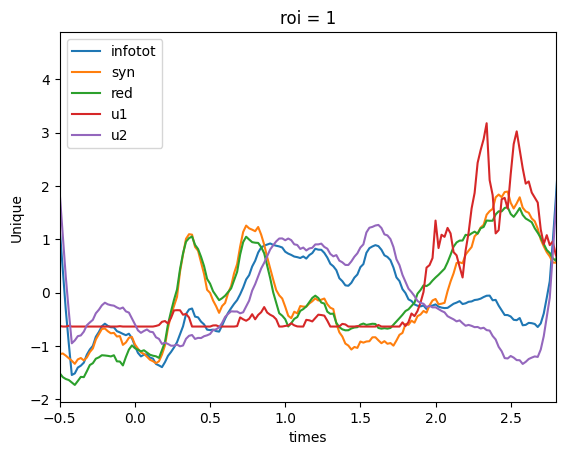

In [133]:
z_score(x).plot()
z_score(y).plot()
z_score(z).plot()
z_score(u1).plot()
z_score(u2).plot()
plt.xlim(-.5, 2.8)
plt.legend(["infotot", "syn", "red", "u1", "u2"])

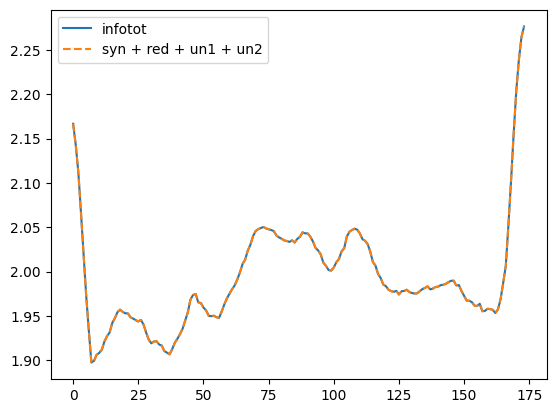

In [127]:
plt.plot(x, label="infotot")
plt.plot(z + y + u1 + u2, "--", label="syn + red + un1 + un2")
plt.legend()

In [83]:
a = unique.data.reshape(data.sizes["roi"], 2, 174).mean(0)

(-0.5, 2.8)

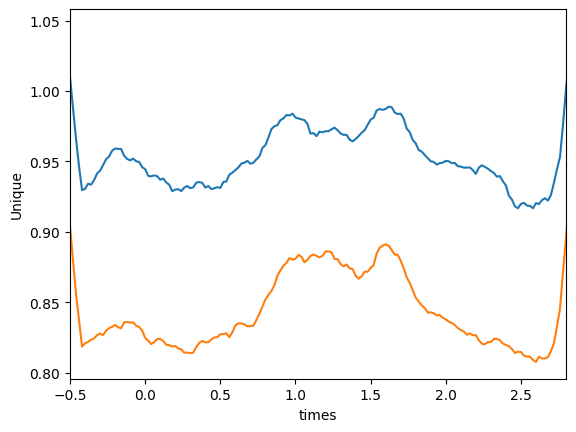

In [85]:
unique.isel(roi=slice(0, data.sizes["roi"])).mean("roi").plot()
unique.isel(roi=slice(data.sizes["roi"], 2 *data.sizes["roi"])).mean("roi").plot()
plt.xlim(-.5, 2.8)

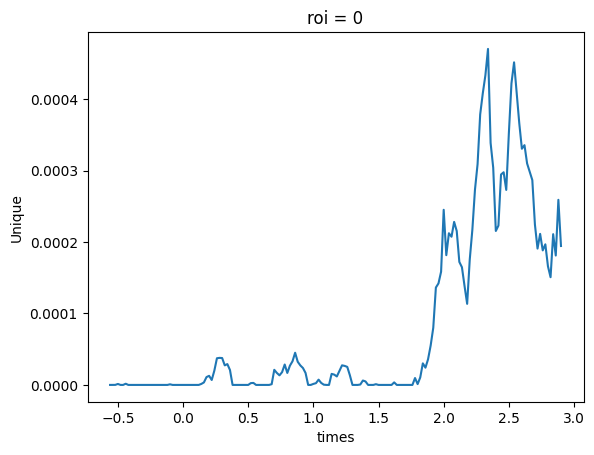

(-0.5, 2.8)

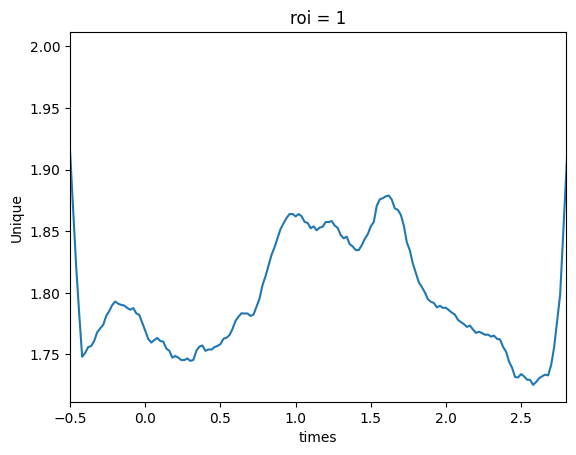

In [101]:
unique.mean("trials").isel(roi=1).plot()
plt.xlim(-.5, 2.8)